In [240]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_absolute_error

## Preparing data

In [147]:
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

In [290]:
def wrangle(file_path, return_dropped_cols:bool = False, is_test_file:bool = False):
    # Reading the data from the file.
    df = pd.read_csv(file_path).set_index("Id")
    
    # Dropping columns having >50% NULL values (NaN)
    missing_values_percent = df.isna().sum() * 100 / len(df)
    missing_values_percent = missing_values_percent[missing_values_percent > 50]
    drop_cols = missing_values_percent.index.to_list()
    
    # # Drop the Id column as it's an index now. 
    # drop_cols.append(df.index.name)
    
    # Drop low cardinality columns
    low_card = df.nunique()
    low_card = low_card[low_card <2]
    low_card = low_card.index.to_list()
    drop_cols.extend(low_card)
    
    # Reformat high cardinality columns 
    columns = df.select_dtypes("object").nunique()
    columns = columns[columns > 4]
    columns = columns.index.to_list()
    threshold = 0.9
    for col in columns:
        df[col] = cumulatively_categorise(df[col], threshold, False)
    
    # Drop columns with multicollinearity
    corr = df.drop(columns=["SalePrice"]).corr()
    for row in corr:
        data = corr[row].drop(row)
        for k, v in data.iteritems():
            if v > 0.5:
                drop_cols.append(k)
    
    # Drop all unneccessary columns. 
    drop_cols = list(set(drop_cols))
    df.drop(columns = drop_cols, inplace=True)
    
    if return_dropped_cols:
        return df, drop_cols
    
    return df 

In [291]:
df = wrangle("data/house-prices-advanced/train.csv")

## Data Exploration

### 1. Data visualization

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 60 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallCond    1460 non-null   int64  
 16  RoofStyle      1460 non-null   object 
 17  RoofMatl       1460 non-null   object 
 18  Exterior

Let's visualize the entire dataset columns

In [221]:
pd.set_option("display.max_columns", None)
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtHalfBath,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,0,150,GasA,Ex,Y,SBrkr,0,0,1,Gd,Typ,0,NaN,Attchd,RFn,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,Other,Gtl,Other,Feedr,Norm,1Fam,1Story,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,0,284,GasA,Ex,Y,SBrkr,0,1,1,TA,Typ,1,TA,Attchd,RFn,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,0,434,GasA,Ex,Y,SBrkr,0,0,1,Gd,Typ,1,TA,Attchd,RFn,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,5,Gable,CompShg,Wd Sdng,Other,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,0,540,GasA,Gd,Y,SBrkr,0,0,1,Gd,Typ,1,Gd,Detchd,Unf,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Other,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,Other,Gtl,NoRidge,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,0,490,GasA,Ex,Y,SBrkr,0,0,1,Gd,Typ,1,TA,Attchd,RFn,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Other,Gd,TA,No,GLQ,Unf,0,64,GasA,Ex,Y,SBrkr,0,0,1,TA,Typ,0,NaN,Attchd,Unf,TA,TA,Y,40,30,0,320,0,0,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,Unf,0,317,GasA,Ex,Y,SBrkr,0,0,1,Gd,Typ,1,Gd,Attchd,RFn,TA,TA,Y,255,57,0,0,0,0,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,Other,Norm,1Fam,2Story,6,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,Other,32,216,GasA,Ex,Y,SBrkr,0,0,1,TA,Typ,2,TA,Attchd,RFn,TA,TA,Y,235,204,228,0,0,0,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Other,Norm,1Fam,1.5Fin,5,Gable,CompShg,Other,Other,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,Unf,0,952,GasA,Gd,Y,Other,0,0,2,TA,Other,2,TA,Detchd,Unf,Other,TA,Y,90,0,205,0,0,0,0,4,2008,WD,Other,129900


#### 2. Identifying NaN columns

Let's check for NULL values. Any feature having >50%  of null values will be dropped. 
In the graph below, anything below the line is kept in tack and any feature above the line will be dropped. 

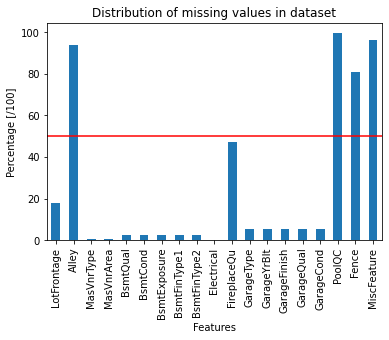

In [79]:
missing_values_percent = df.isna().sum() * 100 / len(df)
missing_values_percent = missing_values_percent[missing_values_percent > 0]
missing_values_percent.plot(kind="bar")
plt.axhline(y=50, color="red", linestyle="-")
plt.xlabel("Features")
plt.ylabel("Percentage [/100]")
plt.title("Distribution of missing values in dataset");

In [136]:
missing_values_ = missing_values_percent[missing_values_percent > 50]
missing_values_

Series([], dtype: float64)

### 3. Finding out High and Low cardinality

In [167]:
df.select_dtypes("object").nunique().sort_values()

Street            2
GarageCond        2
Utilities         2
GarageQual        2
Functional        2
Condition2        2
Electrical        2
CentralAir        2
Heating           2
RoofMatl          2
MSZoning          3
PavedDrive        3
GarageFinish      3
FireplaceQu       3
SaleType          3
ExterCond         3
SaleCondition     3
LotConfig         3
LandSlope         3
Condition1        3
RoofStyle         3
BldgType          3
ExterQual         4
LotShape          4
LandContour       4
GarageType        4
KitchenQual       4
HouseStyle        4
HeatingQC         4
BsmtFinType2      4
BsmtExposure      4
BsmtCond          4
BsmtQual          4
MasVnrType        4
Foundation        4
BsmtFinType1      6
Exterior1st       7
Exterior2nd       7
Neighborhood     18
dtype: int64

We will set the threshold for categorical data at 90%, loop through all categorical data and reclassify them. But only for categorical data having more than 4 unique values.

In [168]:
# columns = df.select_dtypes("object").nunique()
# columns = columns[columns > 4]
# columns = columns.index.to_list()
# threshold = 0.9
# for col in columns:
#     df[col] = cumulatively_categorise(df[col], threshold, False)
# df.select_dtypes("object").nunique()

Let's verify the correlation between low cardinality columns and SalePrice column

In [117]:
d = {"Pave": False, "Grvl": True}
street = df["Street"].map(d).astype(int)
print("Correlation between `Street`.`Grvl` and `SalePrice`:", street.corr(df["SalePrice"]))

d = {"Pave": True, "Grvl": False}
street = df["Street"].map(d).astype(int)
print("Correlation between `Street`.`Pave` and `SalePrice`:", street.corr(df["SalePrice"]))

Correlation between `Street`.`Grvl` and `SalePrice`: -0.04103553550004949
Correlation between `Street`.`Pave` and `SalePrice`: 0.04103553550004951


### 4. Leaky Features

Let's get the hihly correlated columns with `SalePrice`

In [277]:
numeric_data = df.select_dtypes("number")
corr = numeric_data[numeric_data.columns[1:]].corr()["SalePrice"][:].sort_values()
corr

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BsmtUnfSF        0.214479
LotArea          0.263843
OpenPorchSF      0.315856
WoodDeckSF       0.324413
LotFrontage      0.351799
Fireplaces       0.466929
MasVnrArea       0.477493
SalePrice        1.000000
Name: SalePrice, dtype: float64

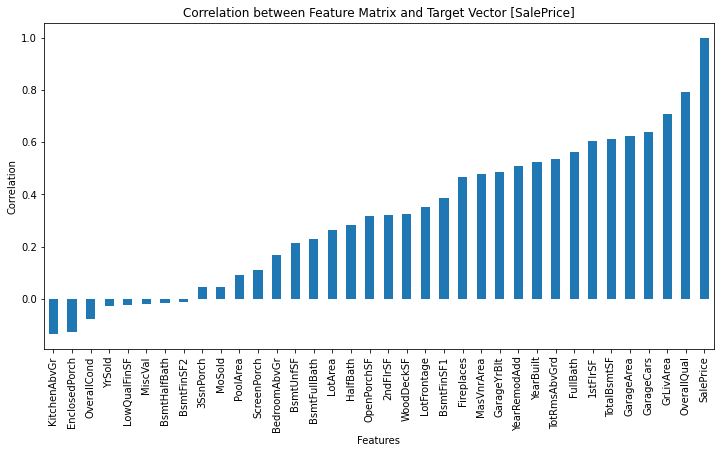

In [189]:
corr.plot.bar(figsize=(12, 6))
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.title("Correlation between Feature Matrix and Target Vector [SalePrice]");

### 5. Multicollineality

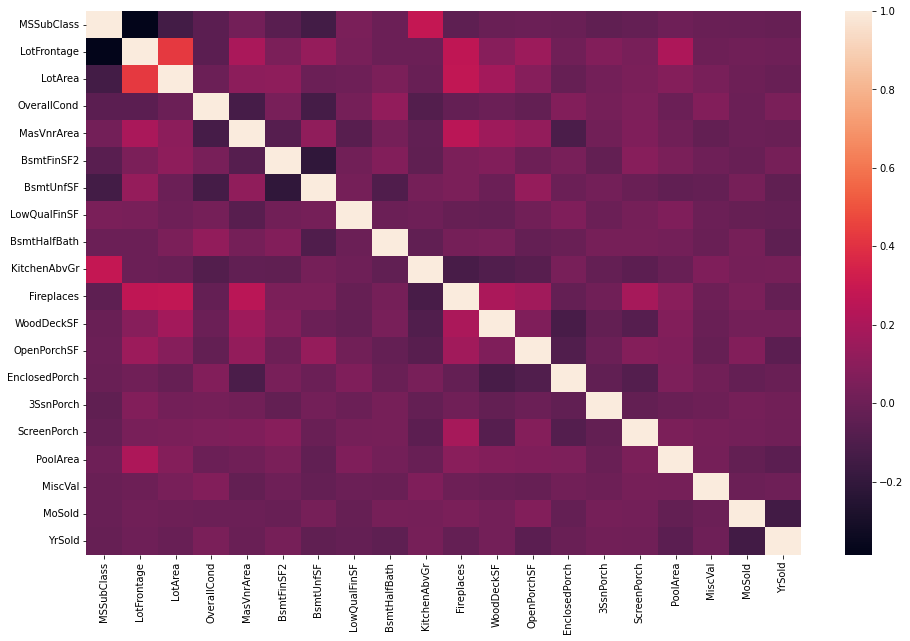

In [222]:
corr = df.drop(columns=["SalePrice"]).corr()
# corr.style.background_gradient(cmap='coolwarm')
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(corr);

In [223]:
# Identifying columns with high multicollinearity. 

# droppable = []
# for row in corr:
#     data = corr[row].drop(row)
#     for k, v in data.iteritems():
#         if v > 0.5:
#             droppable.append(k)
# droppable = list(set(droppable))
# len(droppable)

# 6. Split the data 

In [278]:
cutoff = int(len(df) * 0.85)
target = "SalePrice"
X_train, X_test = df.drop(columns=[target])[:cutoff], df.drop(columns=[target])[cutoff:]
y_train, y_test = df[target][:cutoff], df[target][cutoff:]

In [280]:
df.shape

(1460, 60)

## 7. Build Model

In [249]:
y_mean = y_train.mean()
y_pred = [y_mean] * len(y_train)
print("Baseline MAE:", mean_absolute_error(y_train, y_pred))

Baseline MAE: 57705.43329344367


In [252]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LinearRegression()
)
model.fit(X_train, y_train);

In [256]:
y_pred = model.predict(X_test)
print("Training MAE:", mean_absolute_error(y_test, y_pred))

Training MAE: 26535.583565211185


## 8. Evaluation

Let's make a plot of the predicted values and the actual values.

In [257]:
prediction = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred}, index=y_test.index
)

<AxesSubplot:xlabel='Id'>

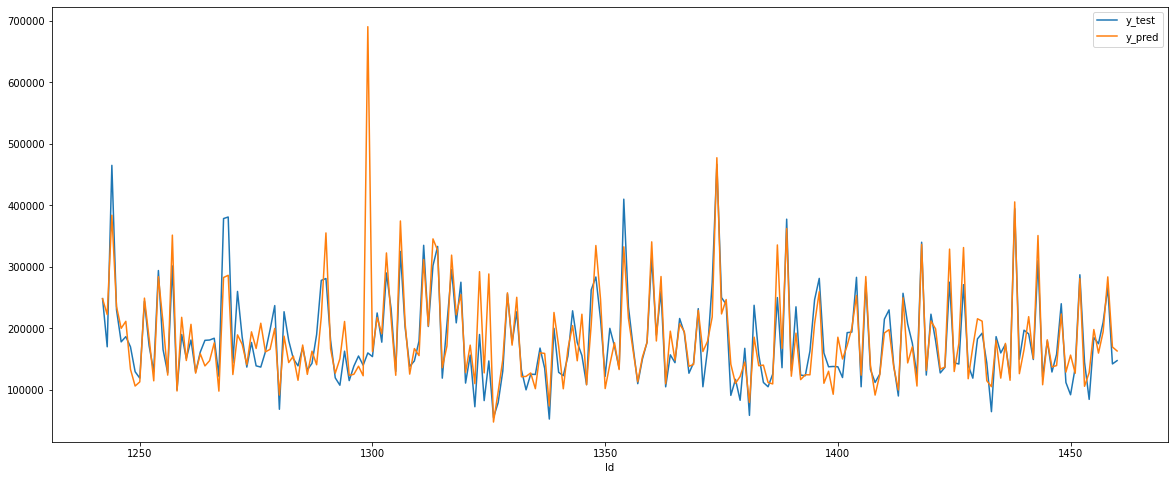

In [263]:
prediction.plot(figsize=(20,8))

In [293]:
_, drop_cols = wrangle("data/house-prices-advanced/train.csv", True)
X_test_data = pd.read_csv("data/house-prices-advanced/test.csv").set_index("Id").drop(columns=drop_cols)

In [295]:
predictions = model.predict(X_test_data)

In [304]:
preds = pd.Series(predictions, index=X_test_data.index)

In [305]:
preds

Id
1461   -1.869184e+13
1462    1.590451e+05
1463    1.821099e+05
1464    1.895279e+05
1465   -1.233497e+10
            ...     
2915   -1.040047e+10
2916   -1.047453e+10
2917   -8.750281e+08
2918   -2.908898e+09
2919    2.229700e+09
Length: 1459, dtype: float64

In [310]:
prediction

,y_test,y_pred
Id,,
1242,248328,248092.140625
1243,170000,222443.316406
1244,465000,383960.667969
1245,230000,235551.152344
1246,178000,199962.359375
...,...,...
1456,175000,159726.285156
1457,210000,194444.078125
1458,266500,283639.843750


In [1]:
import random

In [7]:
int(random.random() * 100000)

88457

In [23]:
from enum import IntEnum, Enum

class TType(Enum):
    INVESTMENT = "invest"
    WITHDRAWAL = "withdraw"

In [11]:
int(TType.INVESTMENT)

1

In [14]:
trans_type = 1

In [15]:
trans_type == TType.INVESTMENT

True

In [19]:
if 5 in list(TType):
    print(True)
else:
    print(False)

False


In [26]:
TType("invest").value

'invest'

In [44]:
from datetime import datetime, timedelta
import math

In [31]:
last = datetime.utcnow() - timedelta(hours=25, minutes=15)

In [54]:
last

datetime.datetime(2022, 4, 19, 6, 42, 54, 12110)

In [52]:
last_interest_calc = last 
accepted_num_of_days = 2

In [53]:
last_interest_calc + timedelta(hours=(accepted_num_of_days * 24))

datetime.datetime(2022, 4, 21, 6, 42, 54, 12110)

In [37]:
15//4

3

In [39]:
a = 23.937

In [40]:
round(a, 2)

23.94

In [42]:
format(a, ".2f")

'23.94'

In [46]:
math.floor(a, 2)

TypeError: floor() takes exactly one argument (2 given)

In [47]:
float_num = 5.8967
 
def truncatenum(num,digits=0):
    multiplier = 10 ** digits
    return int(num * multiplier) / multiplier

In [55]:
import decimal

In [56]:
amount = decimal.Decimal(35.5)

In [59]:
interest = 35.4


In [63]:
total = decimal.Decimal(interest) + amount

In [2]:
from python3_gearman import GearmanAdminClient

In [6]:
admin = GearmanAdminClient(["127.0.0.1:4730"])

In [9]:
status = list(admin.get_status())

In [10]:
len(status)

6

In [24]:
from datetime import datetime, timedelta
(datetime.now() - (datetime.now() - timedelta(days=20))) // timedelta(days=30)

0

In [12]:
for task in status:
    if task["task"] == "notification.project":
        print(True)
        break

True


In [25]:
"hell".upper()

'HELL'

In [27]:
import uuid

In [28]:
str(uuid.uuid4())

'3eaba736-e5e4-4576-98bf-4b786fb75291'